# DSCI 100 GROUP 15 Report

### Hyunseok Jung, Jordan Sanders, Ivie Huang, Eden Vasica

## Introduction

The government of Canada provides historical data on weather and climate. Its' hourly weather data report consists of various climate observations such as temperature, humidity, and wind speed, as well as a column classifying the weather type (e.g. "Mostly Cloudy"). We are excited to test our ability to build a classification model for weather types based on climate observations from this dataset. To make our project more enjoyable and personal, we decided to work with historical weather and climate data provided by the 'Vancouver Intl A' weather station, which is not far from UBC. This facility, located in the Vancouver International Airport, is one of the most significant weather stations in Vancouver that collects measurements for weather forecasts and climate studies hourly. Unlike hourly data reports, daily and monthly data reports do not include a weather column making it impossible to build a classification model.

Considering seasonal climate differences and fluctuations, we decided to focus on weather reports from June, to reduce the number of external factors affecting the observations. As we will be handling an hourly data report, we have sufficient observations to build a classification model. In addition, to minimize the influence of global warming on temperature for our classification model, we will use recent data to train our model: June 2022.

## Methods & Results
1. Download all June 2022 hourly data from the government of Canada website, tidy it, and combine it into one dataframe.
2. Split the data into `training_set` and `testing_set`.
3. Select the predictor variables that results in the highest accuracy in a forward selection process
4. Create a recipe that uses the predictors selected and a model specification with tuning on the number of neighbours using `tune()`. Also Use the `step_scale(all_predictors())` function and the `step_center(all_predictors())` function to scale and center our data. While using `step_upsample` function to solve class imbalance if necessary.
5. Perform a 5-fold cross-validation on the training set using `vfold_cv` function
6. Create a workflow analysis with our recipe and model specification using `workflow()` function
7. Collect the metrics from the workflow analysis using the `collect_metrics` function.
8. Plot the $k$ vs the accuracy and identify which $k$ the most optimal for our data set for k-nn classification. 
9. Create a new model specification for with the identified best value $k$ using the `nearest_neighbor()` function.
10. Train the classifier with the training data set using the `workflow` function. Instead of using `fit` or `fit_resamples`, we will use the `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, we will input the cross-validation model we created earlier.
11. Use our final model to predict on the test dataset `testing_set`
12. Record the accuracy of this prediction, and store this in an object
13. Plot the accuracy of our model on a bar graph for each category of Weather column

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


Initially, as presented in our proposal, we intended to use June 2020 and June 2021 to train our model and use June 2022 data for our testing set. Therefore, although we end up using June 2022 data for our model (which will be described later), our data wrangling and cleaning process includes all of June 2020, 2021, and 2022 data files.

The hourly data report of "Vancouver Intl A" from the government of Canada website can be found at the URL below. The link below will take you to the hourly data report from 2022 June 1st.
https://climate.weather.gc.ca/climate_data/hourly_data_e.html?hlyRange=2013-06-11%7C2022-06-22&dlyRange=2013-06-13%7C2022-06-22&mlyRange=%7C&StationID=51442&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2022&selRowPerPage=25&Line=2&searchMethod=contains&txtStationName=vancouver+intl&timeframe=1&time=LST&time=LST&Year=2022&Month=6&Day=1#

Since the data report with the Weather column is only available on a 24-hour basis, we had to download 30 individual .csv files for June 2020 and June 2021, respectively, and 19 individual .csv files for June 2022 (June 19th data was the most recent file that was available when we started working on our project) from the government of Canada website. 

We first worked locally to clean and wrangle individual .csv files. Then we combined the tidied data into one data frame. Finally, we then uploaded all of them into our Github repository: https://github.com/hyunseokjg/DSCI100-Group15-Project so that the final data set that will be used in our project is readily available and reproducible.

In our Github repository, you can access raw and tidied data for each day, as well as the Jupiter notebook file that was used to clean, wrangle and combine the data files. For convenience, the codes used for 2022 June data are attached below as example.

In [25]:
# Reading in 2022 June 1st data
df1 <- read_csv("data/2022_June_1.csv")

# Renaming Column Names
colnames(df1) <- make.names(colnames(df1))
tidy_df1 <- df1 %>%
    select(Temp...C., Rel.Hum...., Wind.Spd..km.h., Visibility..km., Stn.Press..kPa., Weather) %>%
    filter(Weather != "NA") 
tidy_df1 <- rename(tidy_df1,
       Temp = Temp...C., 
       Humid = Rel.Hum...., 
       Wind_Spd = Wind.Spd..km.h.,
       Vis = Visibility..km., 
       Press = Stn.Press..kPa.)

# Mutating weather column as factor
tidy_df1 <- tidy_df1 %>%
    mutate(Weather = as_factor(Weather))

# Saving tidy data
write_csv(tidy_df1, "data/tidy_2022_June_1.csv")

# Reading in all tidy data of June 2022
df1 <- read_csv("tidy_data/tidy_2022_June_1.csv")
df2 <- read_csv("tidy_data/tidy_2022_June_2.csv")
df3 <- read_csv("tidy_data/tidy_2022_June_3.csv")
df4 <- read_csv("tidy_data/tidy_2022_June_4.csv")
df5 <- read_csv("tidy_data/tidy_2022_June_5.csv")
df6 <- read_csv("tidy_data/tidy_2022_June_6.csv")
df7 <- read_csv("tidy_data/tidy_2022_June_7.csv")
df8 <- read_csv("tidy_data/tidy_2022_June_8.csv")
df9 <- read_csv("tidy_data/tidy_2022_June_9.csv")
df10 <- read_csv("tidy_data/tidy_2022_June_10.csv")
df11 <- read_csv("tidy_data/tidy_2022_June_11.csv")
df12 <- read_csv("tidy_data/tidy_2022_June_12.csv")
df13 <- read_csv("tidy_data/tidy_2022_June_13.csv")
df14 <- read_csv("tidy_data/tidy_2022_June_14.csv")
df15 <- read_csv("tidy_data/tidy_2022_June_15.csv")
df16 <- read_csv("tidy_data/tidy_2022_June_16.csv")
df17 <- read_csv("tidy_data/tidy_2022_June_17.csv")
df18 <- read_csv("tidy_data/tidy_2022_June_18.csv")
df19 <- read_csv("tidy_data/tidy_2022_June_19.csv")

# Merging multiple data file into single table
df_final <- bind_rows(df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19)

# Saving the merged table into .csv file
write_csv(df_final, "tidy_data/testing_set.csv")

ERROR: Error: 'data/2022_June_1.csv' does not exist in current working directory ('/home/jupyter/DSCI100-Group15-Project').


As mentioned above, since we initially intended to use June 2022 data for our testing set, the name of the combined tidy data of June 2022 is called the testing_set.csv. 

While we were working on our model with our training set (combined file with June 2020 and 2021 data), we encountered a problem where the accuracy estimates for different numbers of neighbors returned 100% accuracy for all values of k. Our initial instinct was to test if this pattern persists even if we reduce the number of observations by randomly sampling 1000 observations from our training set. This time, our accuracy was also very high at around 97% for k = 1 and 2, then gradually decreased as the number of neighbors increased. Such problems were unforeseen errors caused by our data set's characteristics. Our weather data is a time-series data where each observation is indexed in time order. So, the recorded variable in the weather column was bound to the observation made at that particular time.
Consequently, the time-related component of our data had a negative impact on the predictions as we increased the number of neighbors. Furthermore, the KNN classification model we covered in DSCI 100 uses a Euclidian distance metric that cannot measure the distance between multiple time series. This suggests a possible reason that accuracy decreases as we increase the number of neighbors. Thus, we suspected that a large number of observations in our training set, 16890 rows (shown below), were disturbing the accuracy measures. As a result, we decided to sample 500 observations from the most recent 2022 data (testing set) to minimize the effect of both time aspects of our data and the influence of global warming on temperature for our classification model.

In [24]:
weather_training_for_display <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/training_set.csv")
nrow(weather_training_for_display)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



[1] 16890

In [4]:
options(repr.matrix.max.rows = 9)
set.seed(2022) #we need this to make our code reproducible, since sample is a random function

weather_data <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/testing_set.csv")
weather_data

#Let's remove the very rare weather classes for simplicity and so we do not overreppresent them when we balance our data

filtered_weather_data <- weather_data %>%
    filter(Weather != "Heavy Rain", 
           Weather != "Moderate Rain",
           Weather != "Clear",
           Weather != "Moderate Rain,Fog") %>%
    mutate(Weather = as_factor(Weather)) %>%
    sample_n(500)
filtered_weather_data

#Now we can split our dataset into training and testing sets using the initial_split function so we don't create our model with the same
#data that we will use to test it later on.

weather_split <- initial_split(filtered_weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
16.8,85,19,48.3,101.65,Mostly Cloudy
17.2,84,18,48.3,101.54,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
15.7,81,12,32.2,102.19,Cloudy
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear


Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.9,81,18,48.3,100.73,Rain Showers
12.0,84,28,32.2,101.89,Mostly Cloudy
15.3,96,21,24.1,100.54,Rain
15.6,77,16,48.3,101.49,Mostly Cloudy
19.0,74,11,48.3,101.18,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
13.1,83,8,32.2,102.08,Mainly Clear
18.6,79,18,48.3,100.48,Mostly Cloudy
18.6,79,18,48.3,100.48,Mostly Cloudy


In [5]:
#check to see if proportions of data are close enough to use or if we should scale up some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
proportions

`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,84,22.28117
Rain Showers,30,7.95756
Rain,103,27.32095
Mainly Clear,47,12.46684


In [6]:
#now because we can see our classes are unbalanced, we want to balance our classes using scale_upsample
ups_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_upsample(Weather, over_ratio = 1, skip = FALSE) %>%
    prep()

#now we create our new data set with balanced classes
upsampled_weather <- bake(ups_recipe, weather_train)

#now we check weather our classes have been properly balanced
upsampled_weather %>% group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,113,29.97347
Rain Showers,113,29.97347
Rain,113,29.97347
Mainly Clear,113,29.97347


In [7]:
#now we will create the functions we will use many times later in forward selection and our final model. 
weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather)

k_grid <- tibble(neighbors = 1:30)

### Forward Selection - Predictor Variable Selection Process

#### Phase 1: One Variable

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4994384,5,0.02650572,Model02
1,accuracy,multiclass,0.4885592,5,0.01977678,Model01
3,accuracy,multiclass,0.4567641,5,0.02853445,Model03
4,accuracy,multiclass,0.4458139,5,0.01064819,Model04
7,accuracy,multiclass,0.4381611,5,0.01966626,Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
15,accuracy,multiclass,0.3633759,5,0.01802984,Model15
18,accuracy,multiclass,0.3609180,5,0.01089156,Model18
17,accuracy,multiclass,0.3609152,5,0.01590399,Model17


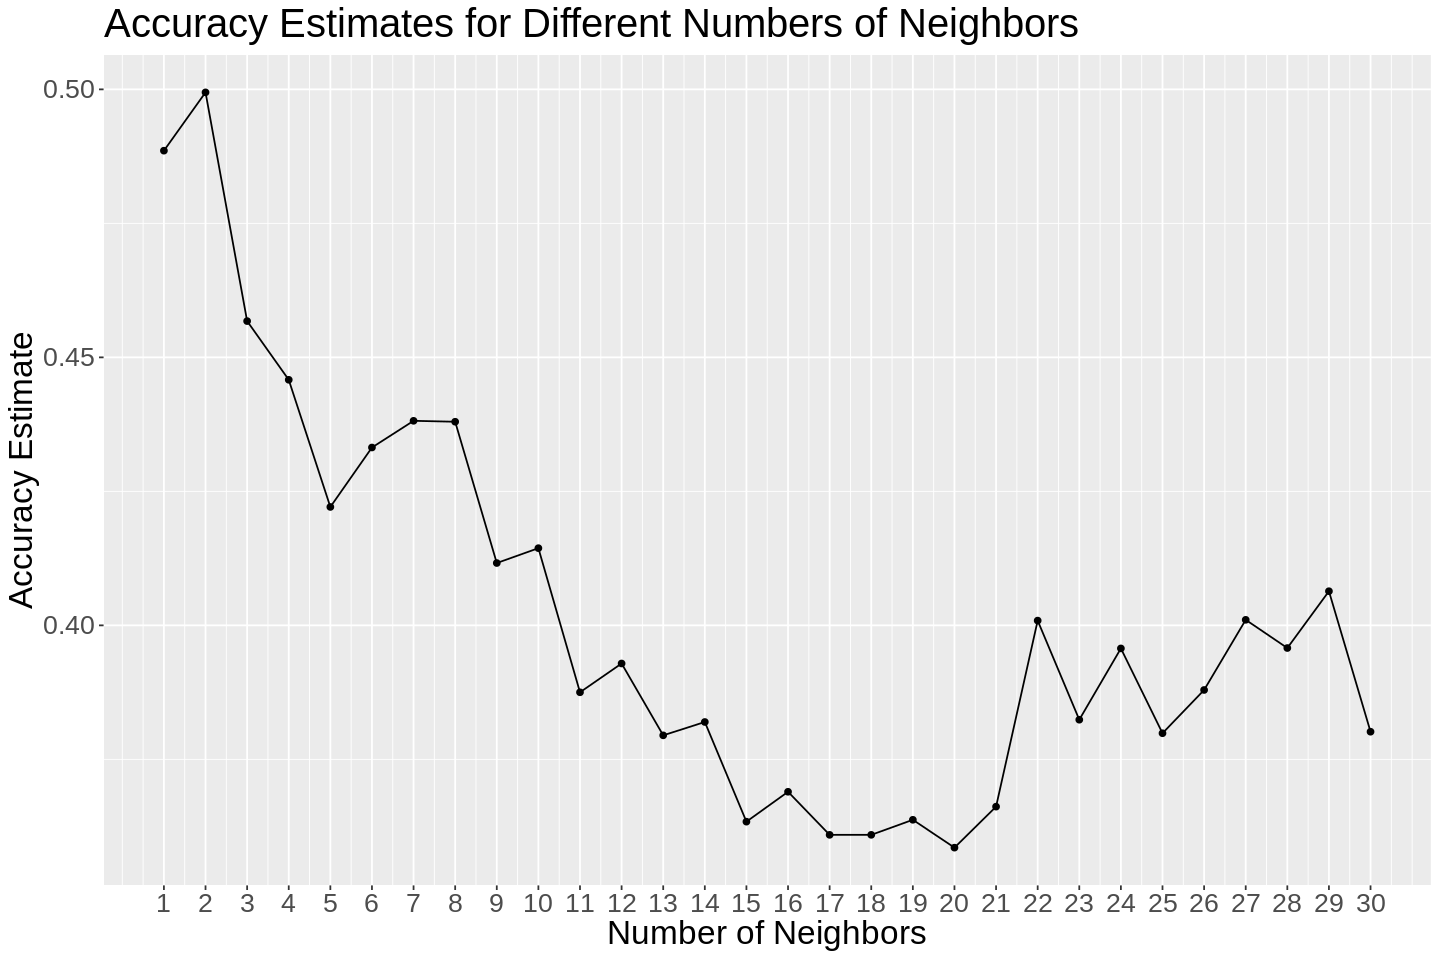

In [8]:
# Model 1.1 - Temperature
temp_recipe <- recipe(Weather ~ Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp_fit <- workflow() %>%
    add_recipe(temp_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp_accuracy <- temp_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp_accuracy


options(repr.plot.height = 8, repr.plot.width = 12)
temp_accuracy_plot <- temp_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
temp_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,multiclass,0.4914042,5,0.02361672,Model13
12,accuracy,multiclass,0.4860699,5,0.02611712,Model12
11,accuracy,multiclass,0.4805934,5,0.02184776,Model11
14,accuracy,multiclass,0.4699590,5,0.02123617,Model14
24,accuracy,multiclass,0.4644483,5,0.01746612,Model24
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,accuracy,multiclass,0.4243659,5,0.01777317,Model01
3,accuracy,multiclass,0.4191369,5,0.01577194,Model03
2,accuracy,multiclass,0.4137315,5,0.01567905,Model02


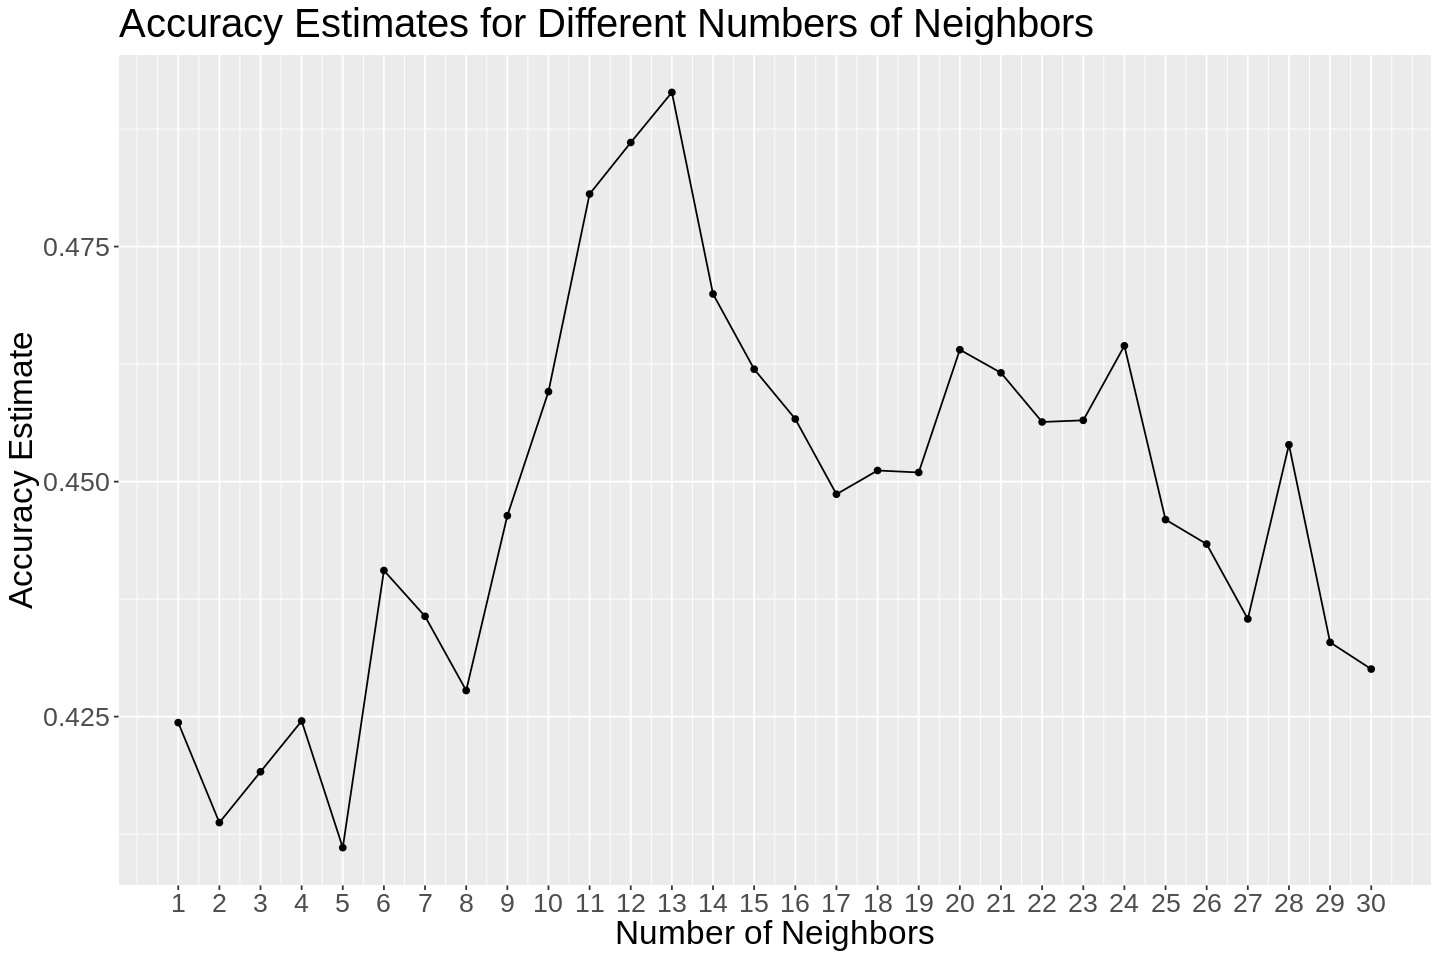

In [9]:
# Model 2.1 - Humidity
humid_recipe <- recipe(Weather ~ Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid_fit <- workflow() %>%
    add_recipe(humid_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid_accuracy <- humid_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid_accuracy

humid_accuracy_plot <- humid_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
humid_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,multiclass,0.4164083,5,0.01925932,Model09
6,accuracy,multiclass,0.4137740,5,0.01284526,Model06
11,accuracy,multiclass,0.4109688,5,0.02036915,Model11
7,accuracy,multiclass,0.4086873,5,0.01571150,Model07
8,accuracy,multiclass,0.4083344,5,0.01307402,Model08
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,accuracy,multiclass,0.3501099,5,0.005746549,Model22
1,accuracy,multiclass,0.3476520,5,0.012485936,Model01
21,accuracy,multiclass,0.3449179,5,0.009729272,Model21


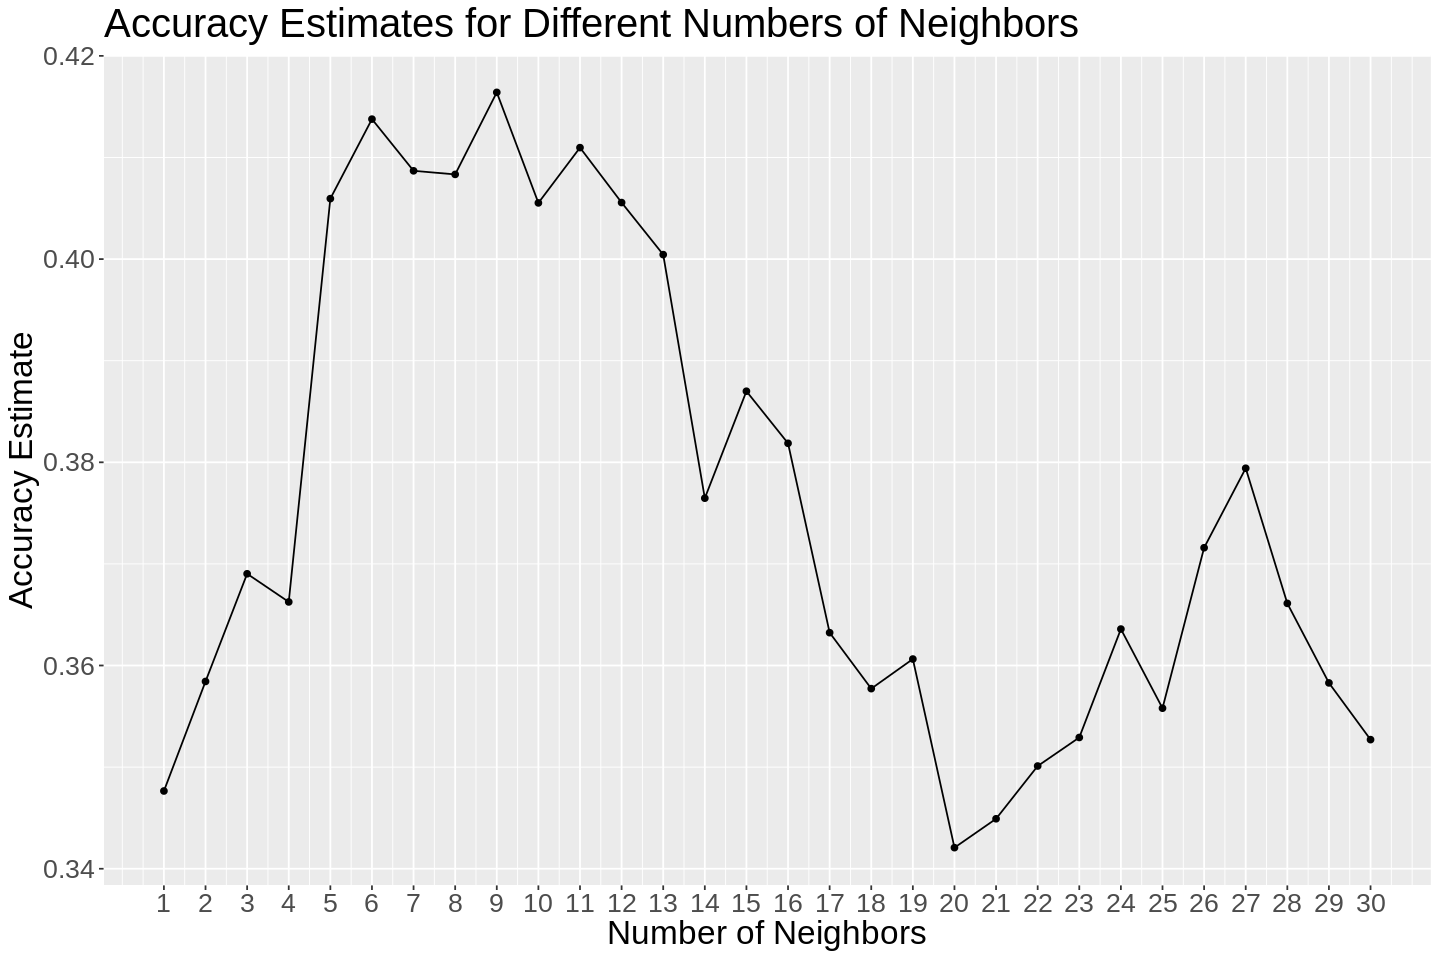

In [10]:
# Model 3.1 - Wind Speed
wind_recipe <- recipe(Weather ~ Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind_fit <- workflow() %>%
    add_recipe(wind_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind_accuracy <- wind_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind_accuracy

wind_accuracy_plot <- wind_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
wind_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,accuracy,multiclass,0.4804881,5,0.01611676,Model16
17,accuracy,multiclass,0.4804881,5,0.01611676,Model17
18,accuracy,multiclass,0.4804881,5,0.01611676,Model18
19,accuracy,multiclass,0.4804881,5,0.01611676,Model19
22,accuracy,multiclass,0.4804881,5,0.01611676,Model22
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,multiclass,0.3636576,5,0.01253204,Model03
4,accuracy,multiclass,0.3636576,5,0.01253204,Model04
1,accuracy,multiclass,0.3050516,5,0.02861168,Model01


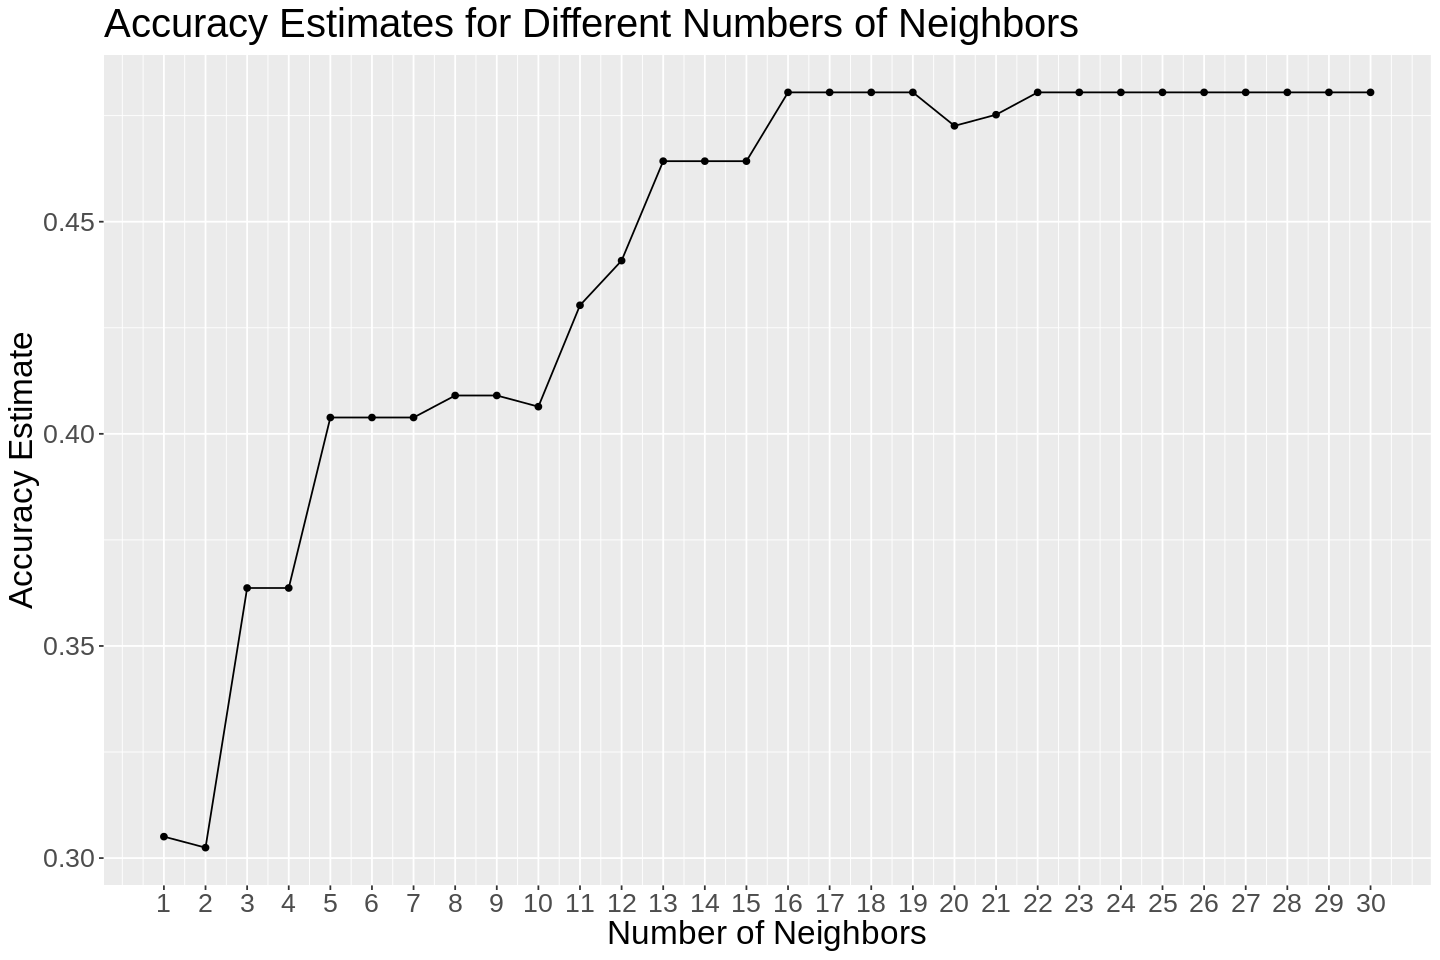

In [11]:
# Model 4.1 - Visability
vis_recipe <- recipe(Weather ~ Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis_fit <- workflow() %>%
    add_recipe(vis_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis_accuracy <- vis_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis_accuracy

vis_accuracy_plot <- vis_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
vis_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.6529401,5,0.03081129,Model02
1,accuracy,multiclass,0.6500268,5,0.02554320,Model01
3,accuracy,multiclass,0.6207607,5,0.01651252,Model03
4,accuracy,multiclass,0.5916998,5,0.03438148,Model04
6,accuracy,multiclass,0.5434040,5,0.03097315,Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,accuracy,multiclass,0.4424369,5,0.02319583,Model14
12,accuracy,multiclass,0.4371340,5,0.03191236,Model12
15,accuracy,multiclass,0.4346844,5,0.01380013,Model15


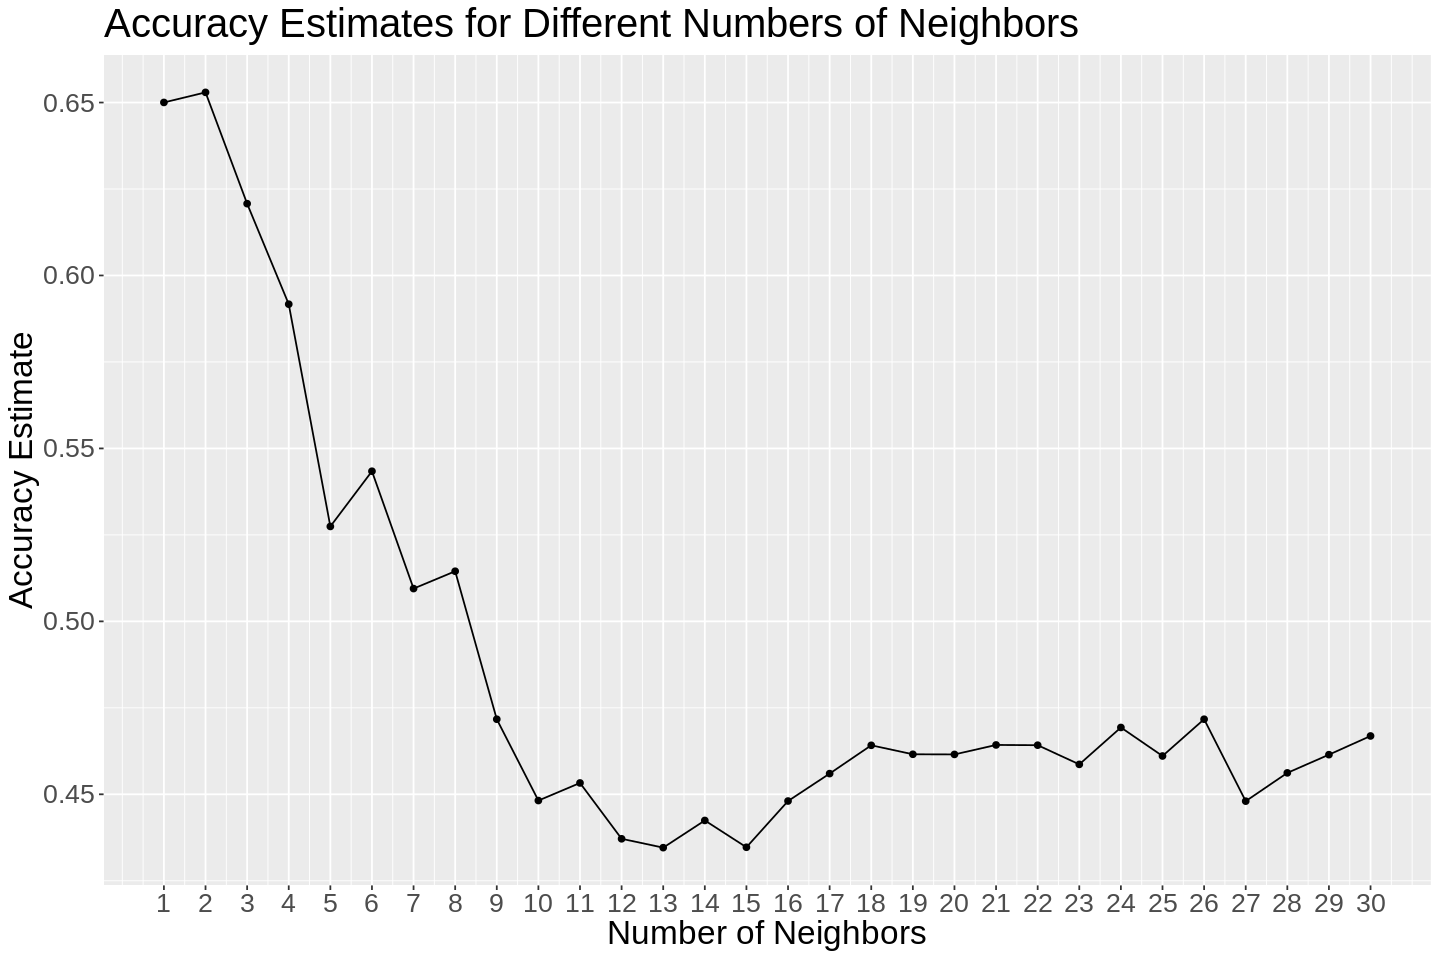

In [12]:
# Model 5.1 - Air Pressure
press_recipe <- recipe(Weather ~ Press, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

press_fit <- workflow() %>%
    add_recipe(press_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

press_accuracy <- press_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
press_accuracy

press_accuracy_plot <- press_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
press_accuracy_plot

**Findings:** Using air pressure has the highest prediction accuracy so far.

In [13]:
#### Phase 2: Two Predictor Variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8649933,5,0.01412293,Model01
2,accuracy,multiclass,0.8649933,5,0.01412293,Model02
3,accuracy,multiclass,0.6865299,5,0.02144021,Model03
4,accuracy,multiclass,0.6547348,5,0.02529086,Model04
5,accuracy,multiclass,0.5410966,5,0.01874295,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.4328352,5,0.02485724,Model28
27,accuracy,multiclass,0.4301325,5,0.02464690,Model27
26,accuracy,multiclass,0.4275692,5,0.02192390,Model26


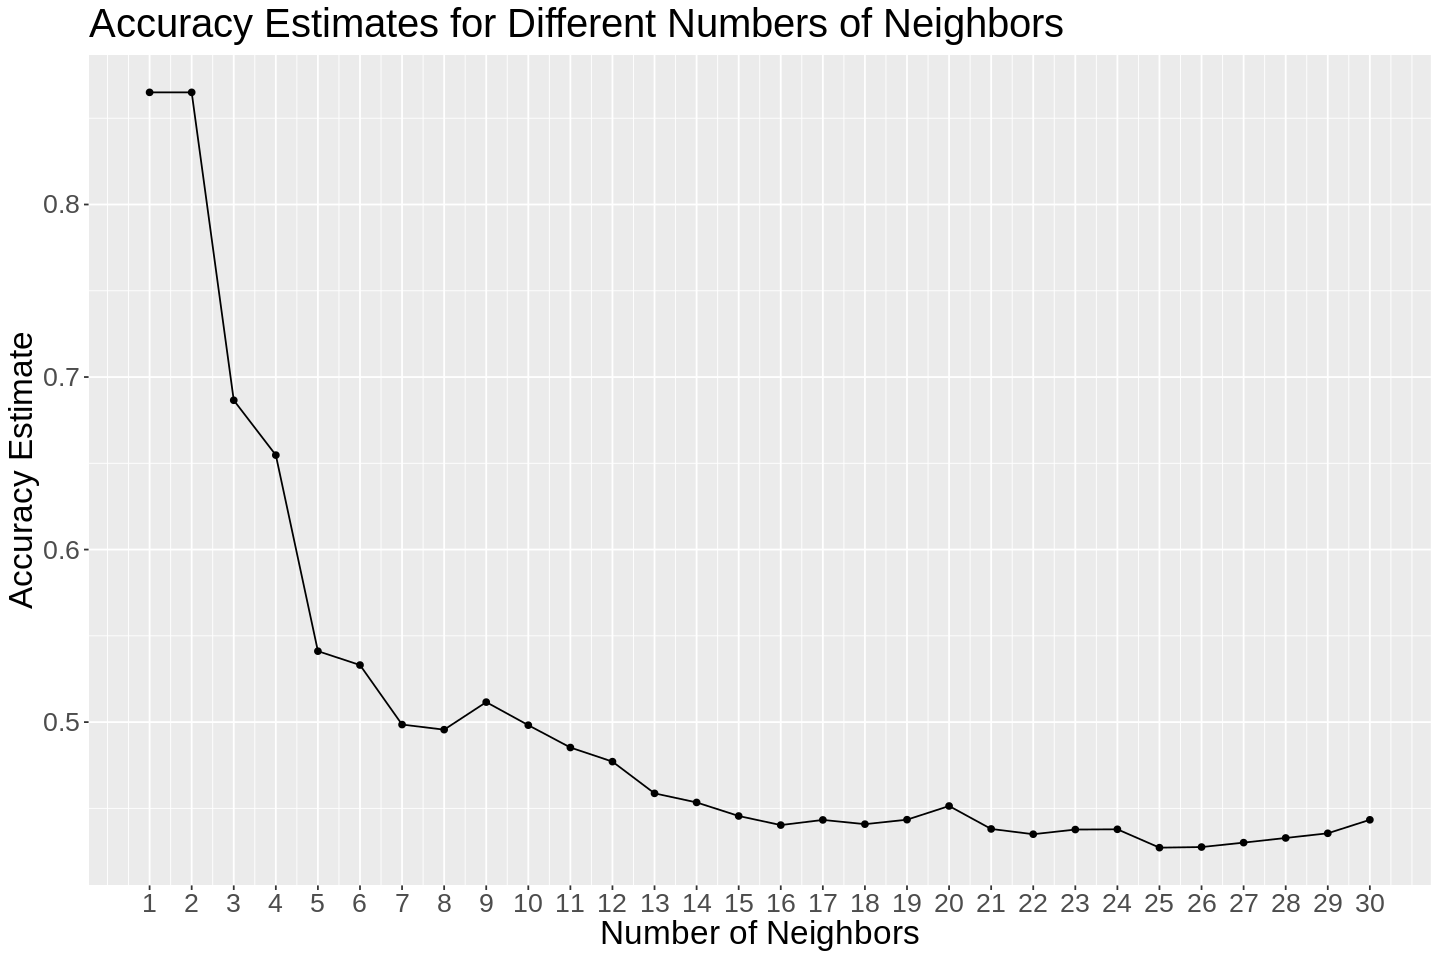

In [14]:
# Model 1.2 - Air Pressure + Temperature
temp2_recipe <- recipe(Weather ~ Press + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp2_fit <- workflow() %>%
    add_recipe(temp2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp2_accuracy <- temp2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp2_accuracy

temp2_accuracy_plot <- temp2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
temp2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8570246,5,0.01927193,Model02
1,accuracy,multiclass,0.8543219,5,0.01918637,Model01
3,accuracy,multiclass,0.7186751,5,0.03917754,Model03
4,accuracy,multiclass,0.6339186,5,0.03416537,Model04
5,accuracy,multiclass,0.5436201,5,0.03081395,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
20,accuracy,multiclass,0.4694639,5,0.01834898,Model20
23,accuracy,multiclass,0.4670457,5,0.02401777,Model23
19,accuracy,multiclass,0.4643772,5,0.02283671,Model19


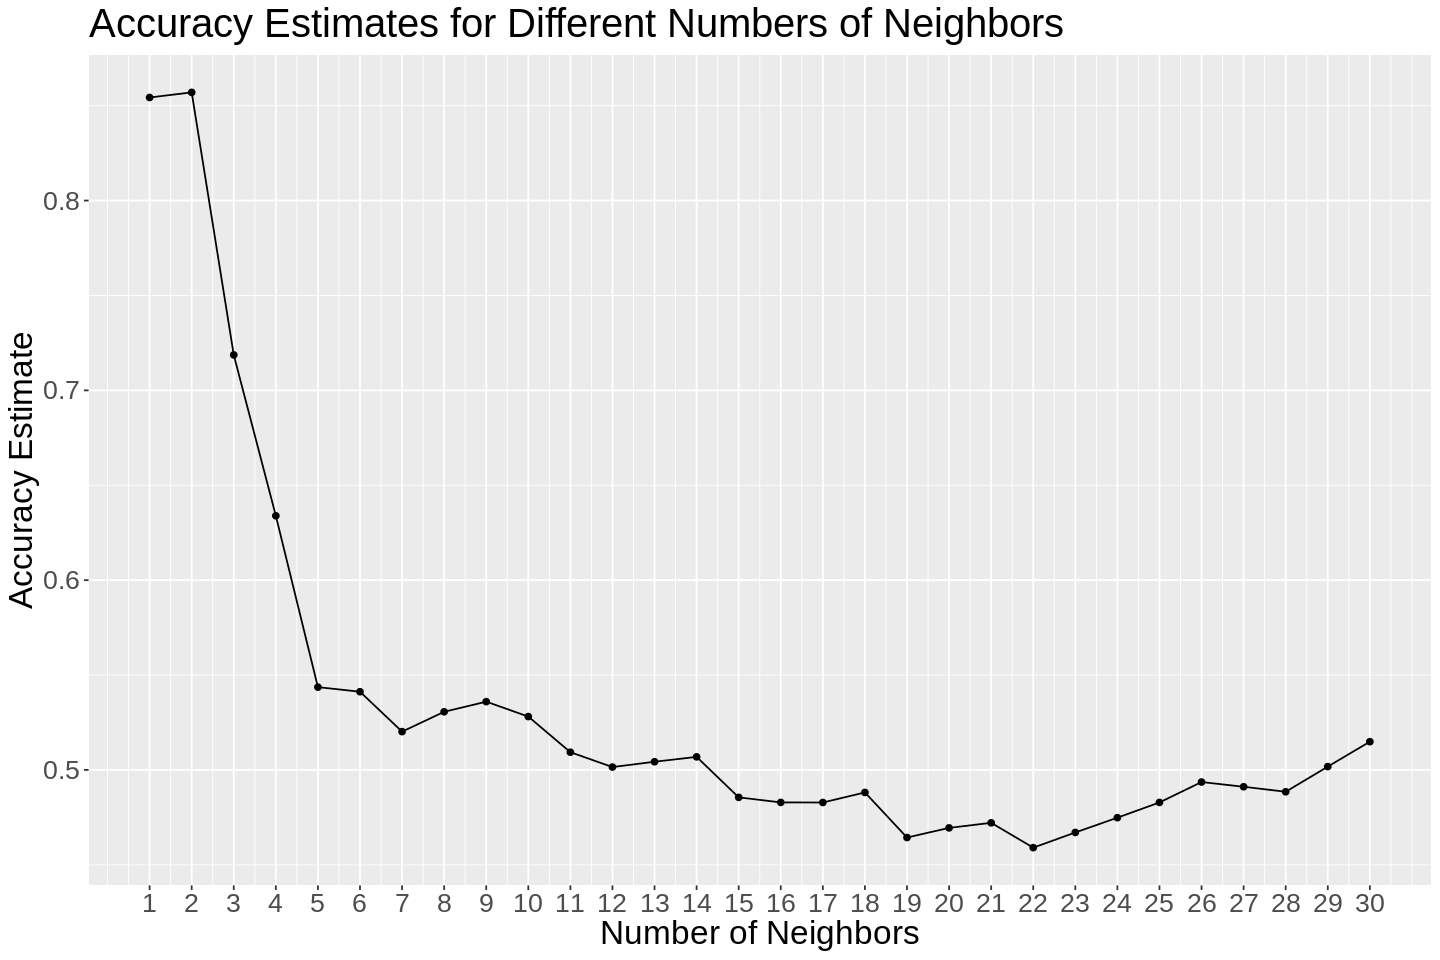

In [15]:
# Model 2.2 - Air Pressure + Humidity
humid2_recipe <- recipe(Weather ~ Press + Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid2_fit <- workflow() %>%
    add_recipe(humid2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid2_accuracy <- humid2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid2_accuracy

humid2_accuracy_plot <- humid2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
humid2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8595879,5,0.015007622,Model01
2,accuracy,multiclass,0.8568851,5,0.013743334,Model02
3,accuracy,multiclass,0.6735826,5,0.019778695,Model03
4,accuracy,multiclass,0.6233240,5,0.015195948,Model04
5,accuracy,multiclass,0.5518021,5,0.009966757,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
25,accuracy,multiclass,0.2870407,5,0.02555790,Model25
29,accuracy,multiclass,0.2841985,5,0.02019072,Model29
30,accuracy,multiclass,0.2817775,5,0.02998889,Model30


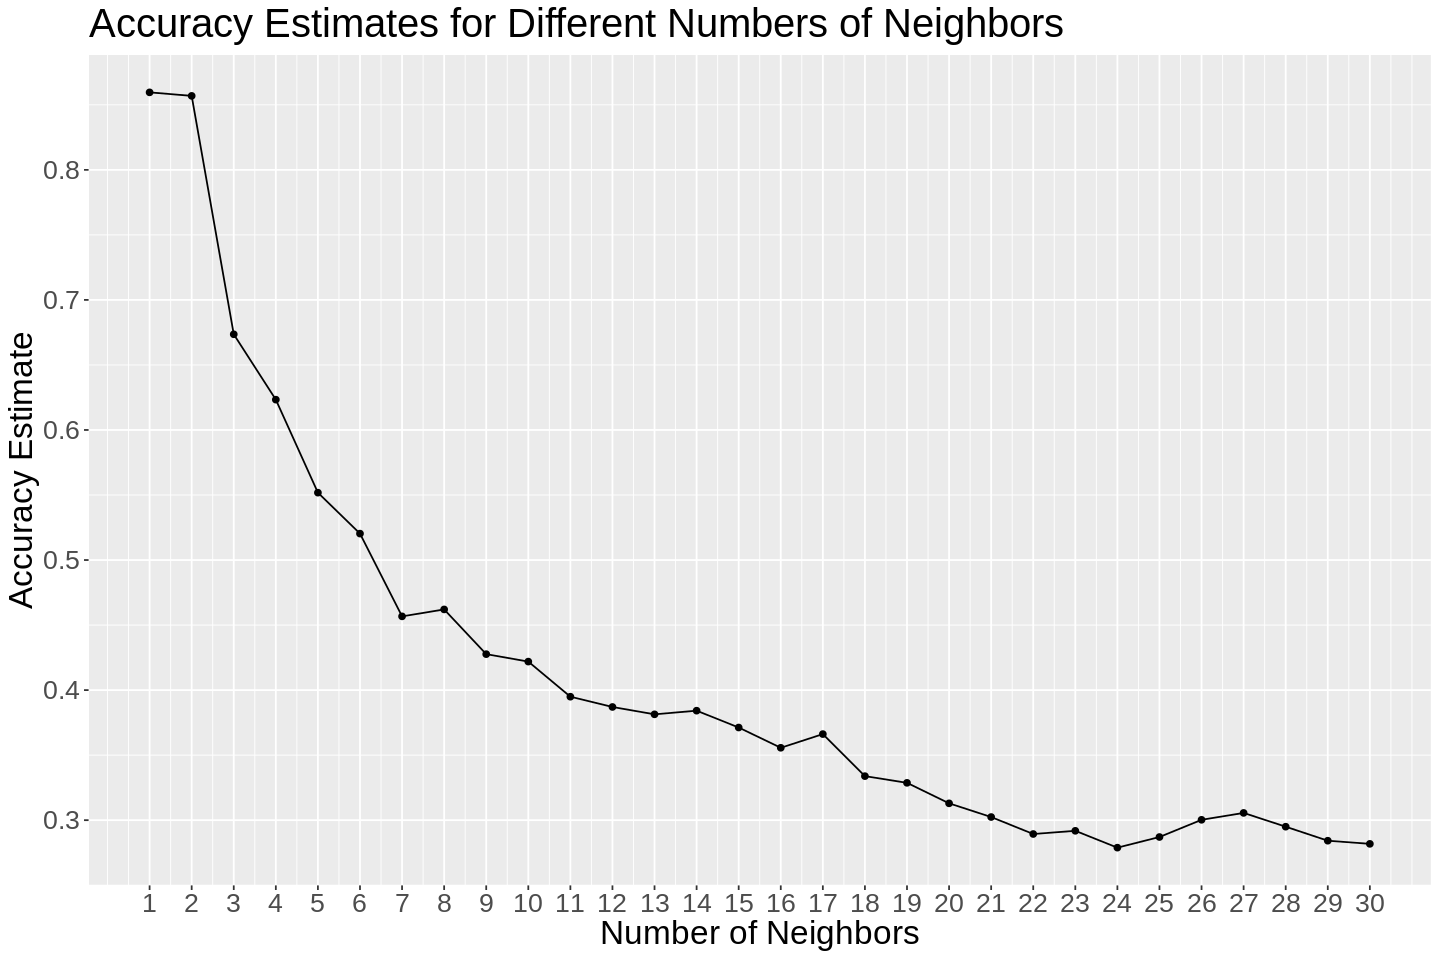

In [16]:
# Model 3.2 - Air Pressure + Wind Speed
wind2_recipe <- recipe(Weather ~ Press + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind2_fit <- workflow() %>%
    add_recipe(wind2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind2_accuracy <- wind2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind2_accuracy

wind2_accuracy_plot <- wind2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
wind2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8010816,5,0.01107796,Model01
2,accuracy,multiclass,0.7847943,5,0.01488608,Model02
3,accuracy,multiclass,0.6527748,5,0.02754873,Model03
4,accuracy,multiclass,0.6424193,5,0.03042237,Model04
5,accuracy,multiclass,0.5811393,5,0.01385300,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.4882119,5,0.01763909,Model28
30,accuracy,multiclass,0.4827354,5,0.01962646,Model30
26,accuracy,multiclass,0.4827354,5,0.01604267,Model26


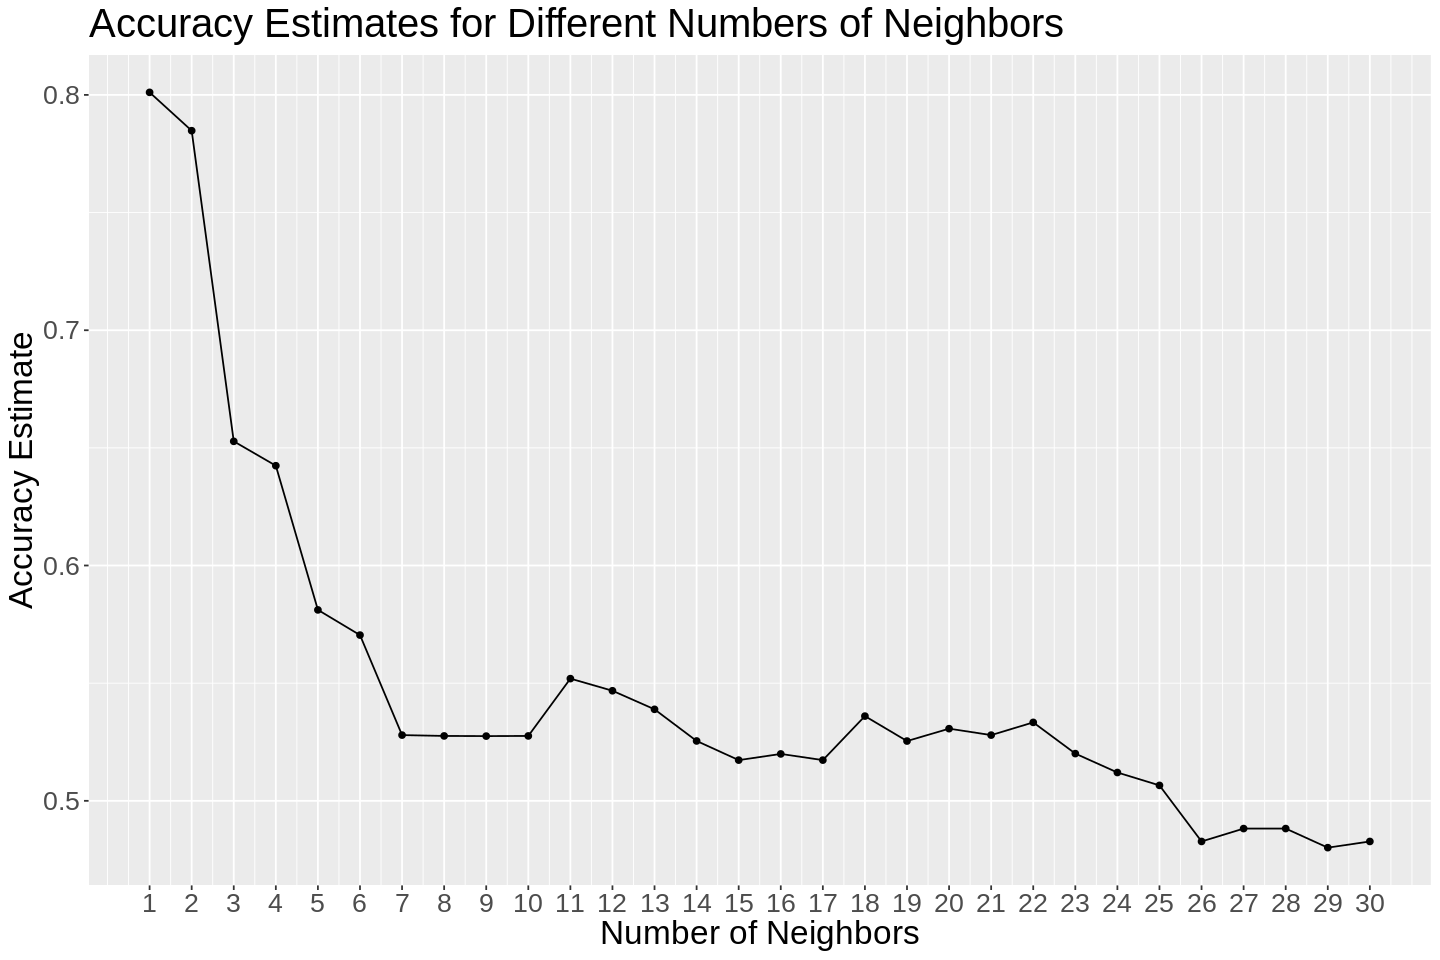

In [17]:
# Model 4.2 - Air Pressure + Visibility
vis2_recipe <- recipe(Weather ~ Press + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis2_fit <- workflow() %>%
    add_recipe(vis2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis2_accuracy <- vis2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis2_accuracy

vis2_accuracy_plot <- vis2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
vis2_accuracy_plot

**Findings:** Using air pressure and humidity has the highest accuracy so far.

#### Phase 3: Three Variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8595537,5,0.01819207,Model01
2,accuracy,multiclass,0.8595537,5,0.01819207,Model02
3,accuracy,multiclass,0.7054460,5,0.01689570,Model03
4,accuracy,multiclass,0.6471532,5,0.02406313,Model04
5,accuracy,multiclass,0.5257967,5,0.02942893,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,accuracy,multiclass,0.4565563,5,0.01689521,Model14
19,accuracy,multiclass,0.4460642,5,0.02725670,Model19
13,accuracy,multiclass,0.4435351,5,0.02237163,Model13


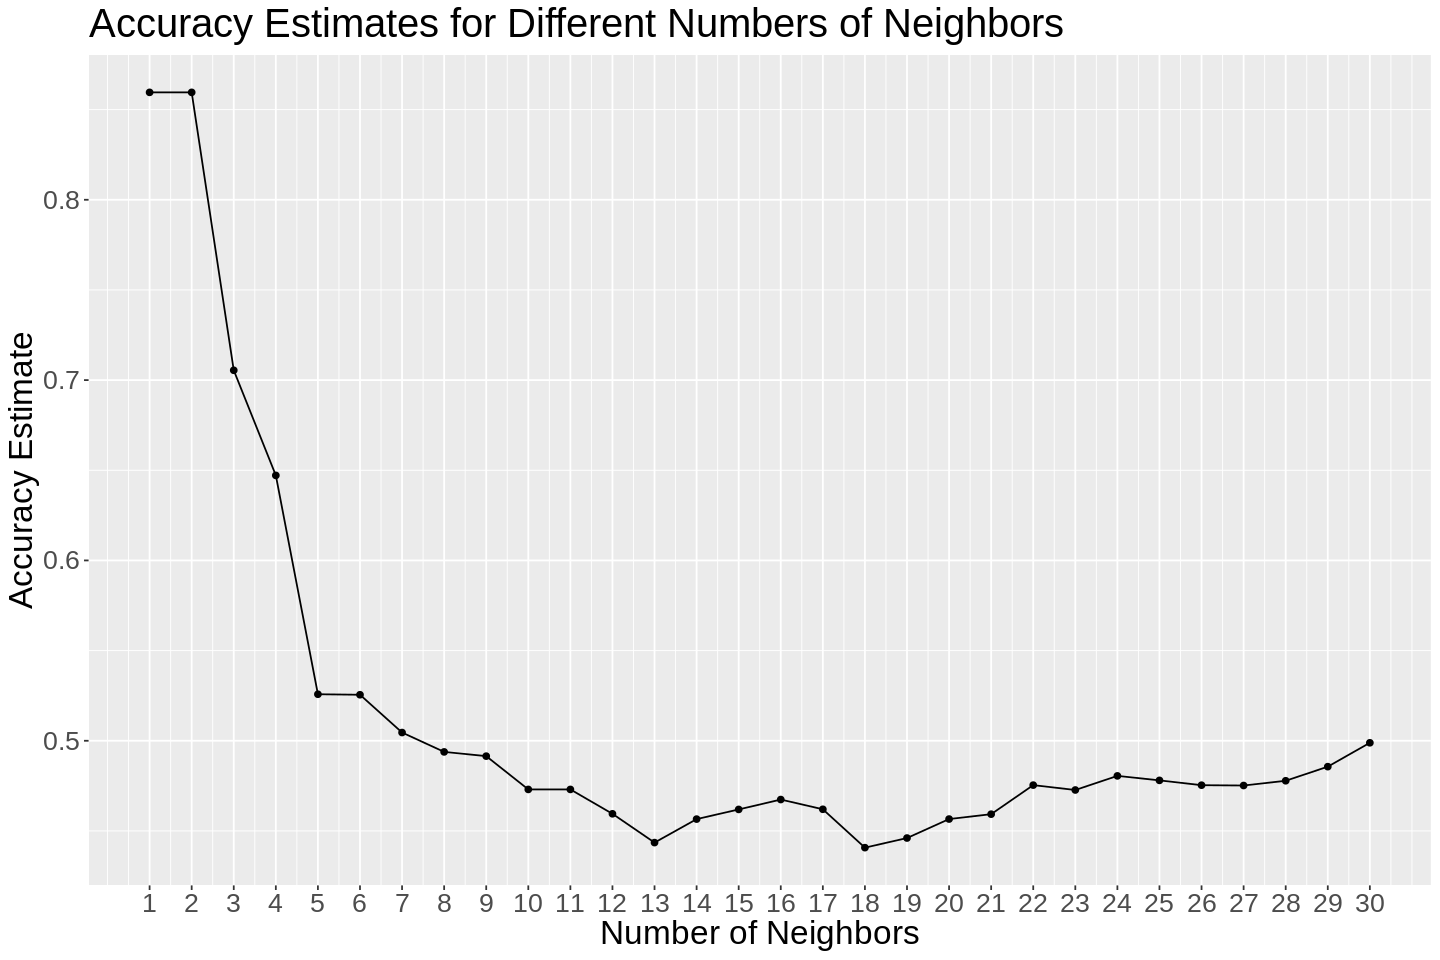

In [18]:
# Model 1.3 - Air Pressure + Humidity + Temperature
temp3_recipe <- recipe(Weather ~ Press + Humid + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp3_fit <- workflow() %>%
    add_recipe(temp3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp3_accuracy <- temp3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp3_accuracy

temp3_accuracy_plot <- temp3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
temp3_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8545011,5,0.01943010,Model02
1,accuracy,multiclass,0.8517984,5,0.01777762,Model01
3,accuracy,multiclass,0.7349365,5,0.04089842,Model03
4,accuracy,multiclass,0.6662485,5,0.03302152,Model04
5,accuracy,multiclass,0.5761209,5,0.03455219,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.4140529,5,0.01735081,Model28
18,accuracy,multiclass,0.4063688,5,0.01839341,Model18
29,accuracy,multiclass,0.4061213,5,0.01750411,Model29


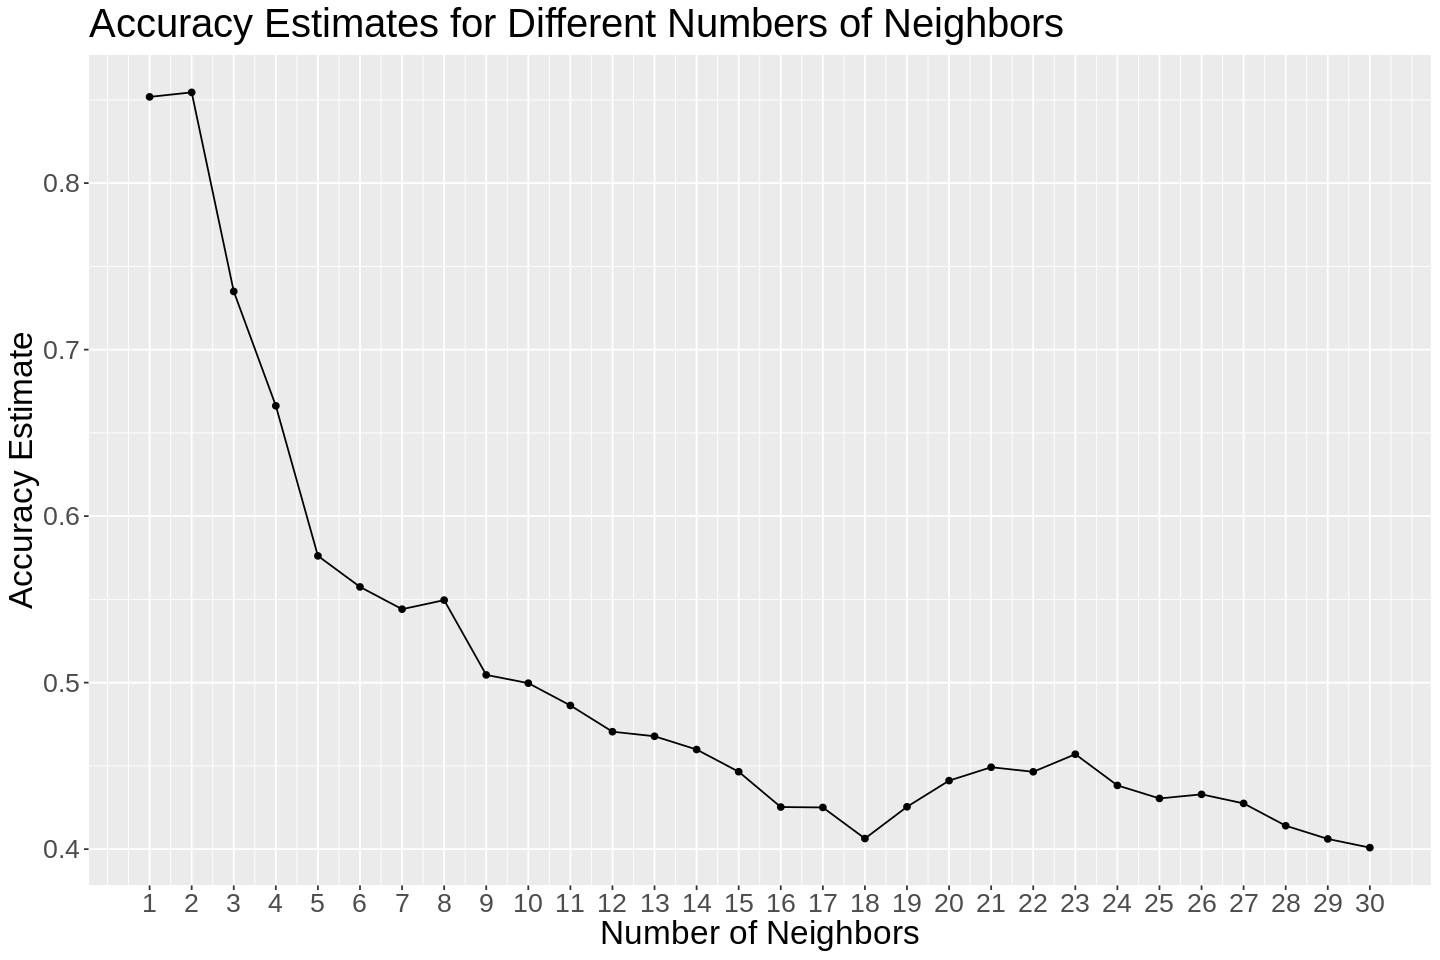

In [19]:
# Model 2.3 - Air Pressure + Humidity + Wind Speed
wind3_recipe <- recipe(Weather ~ Press + Humid + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind3_fit <- workflow() %>%
    add_recipe(wind3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind3_accuracy <- wind3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind3_accuracy

wind3_accuracy_plot <- wind3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
wind3_accuracy_plot

In [20]:
# Model 3.3 - Air Pressure + Humidity + Visibility
vis3_recipe <- recipe(Weather ~ Press + Humid + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis3_fit <- workflow() %>%
    add_recipe(vis3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis3_accuracy <- vis3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis3_accuracy

vis3_accuracy_plot <- vis3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() =
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
vis3_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8621853,5,0.02167457,Model01
2,accuracy,multiclass,0.8568851,5,0.02076684,Model02
3,accuracy,multiclass,0.7217362,5,0.03619253,Model03
4,accuracy,multiclass,0.6740038,5,0.04131536,Model04
5,accuracy,multiclass,0.5967579,5,0.03394769,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
16,accuracy,multiclass,0.4990939,5,0.02246795,Model16
29,accuracy,multiclass,0.4934723,5,0.01179483,Model29
15,accuracy,multiclass,0.4882831,5,0.02069972,Model15


ERROR: Error in vis3_accuracy_plot <- vis3_accuracy %>% ggplot(aes(x = neighbors, : object 'vis3_accuracy_plot' not found


**Findings:** Using air Pressure, humidity and visibility has the highest accuracy so far.

#### Phase 4: Four Variables

In [ ]:
# Model 1.4 - Air Pressure + Humidity + Visibility + Temp
temp4_recipe <- recipe(Weather ~ Press + Humid + Vis + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp4_fit <- workflow() %>%
    add_recipe(temp4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp4_accuracy <- temp4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp4_accuracy

temp4_accuracy_plot <- temp4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
temp4_accuracy_plot

In [ ]:
# Model 2.4 - Air Pressure + Humidity + Visibility + Wind Speed
wind4_recipe <- recipe(Weather ~ Press + Humid + Vis + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind4_fit <- workflow() %>%
    add_recipe(wind4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind4_accuracy <- wind4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind4_accuracy

wind4_accuracy_plot <- wind4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
wind4_accuracy_plot

**Findings:** Using air Pressure, humidity, visibility and temperature has the highest in phase 4, but is not more accurate than the previous.

#### Phase 5: All variables

In [ ]:
# Model 1.5 - Air Pressure + Humidity + Visibility + Wind Speed + Temperature
all_recipe <- recipe(Weather ~ ., data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

all_fit <- workflow() %>%
    add_recipe(all_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

all_accuracy <- all_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
all_accuracy

all_accuracy_plot <- all_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
all_accuracy_plot

**Findings:** Using all predictor variables is still slightly less accurate than using the 3 variables identified in phase 3. Thus we will be using *air pressure*, *humidity*, and *visibility* as predictors in our final model. 

In [ ]:
set.seed(2022) #we need this to make our code reproducible because cross validation is a random process

#make final recipe with cross validation to find k

weather_recipe <- recipe(Weather ~ Press + Humid + Vis, data = weather_train) %>% 
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
weather_accuracy

In [ ]:
#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
finding_k_plot

In [ ]:
#retrain our model with the newfound value of k and fit it to our training data

#since k = 2 has the highest accuracy, we will use that in our new model

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = weather_train)

In [ ]:
#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather)
weather_predictions

In [ ]:
#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

## Discussion

## References